# Titanic - Machine Learning from Disaster 
The data has been split into two groups:
    
- training set (train.csv)
- test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import re

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer as lb_style
from sklearn.preprocessing import LabelEncoder

sns.set()

## Data Dictionary: Variable	Definition	Key
- survival: Survival; 0 = No, 1 = Yes
- pclass: Ticket class; 1 = 1st, 2 = 2nd, 3 = 3rd
- sex: Sex
- Age: Age in years
- sibsp: # of siblings / spouses aboard the Titanic
- parch: # of parents / children aboard the Titanic
- ticket: Ticket number
- fare: Passenger fare
- cabin: Cabin number
- embarked: Port of Embarkation; C = Cherbourg (France), Q = Queenstown (Canada?), S = Southampton (UK)

In [2]:
training_df = pd.read_csv('titanic/train.csv')
training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
training_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


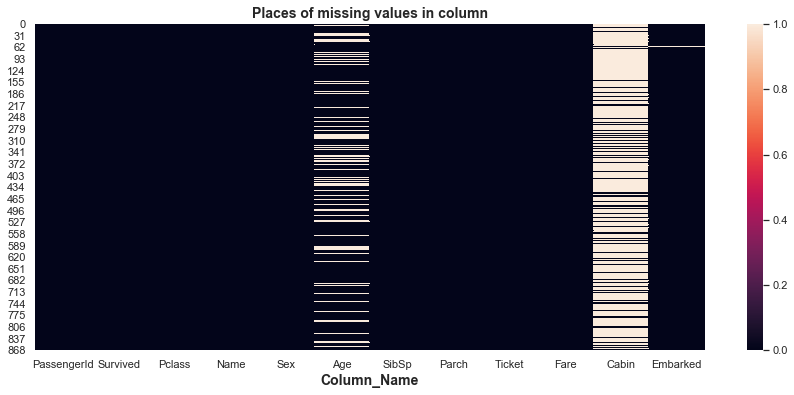

In [6]:
plt.figure(figsize=(15, 6))
sns.heatmap(training_df.isnull())
plt.xlabel("Column_Name", size=14, weight="bold")
plt.title("Places of missing values in column",fontweight="bold",size=14)
plt.show()

## Information to based on summarized data
In the training data:
- There are 891 passengers 
- Only 714 passengers have an age 
- Ticket column is a bit strange, sometimes numeric, sometimes alphanumeric, need to organize somehow, maybe create new column
- Will need to convert Sex column into numeric

Some possible correlations to be made with this data set:
- ticket class correlated to fare
- cabin number correlated to ticket class

## Need to do data preprocessing
- Gender, Ticket, Cabin


In [561]:
### Create a new column where  male = 0 and female = 1
# training_df['Gender'] = training_df.Sex.map( lambda x: 0 if x == 'male' else 1)

training_df['Gender'] = training_df['Sex'].map({'male':0,'female':1})
training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [564]:
# Removing periods and slashes from ticket_number
training_df['Ticket_clean'] = training_df['Ticket'].str.replace('.', '')
training_df['Ticket_clean'] = training_df['Ticket_clean'].str.replace('/', '')

# Converting 'LINE' tickets to '0'
training_df['Ticket_clean'] = training_df['Ticket_clean'].str.replace('LINE', '0')

# Adding dummy prefix NA to tickets that don't have a prefix
training_df['Ticket_clean'] = training_df.Ticket_clean.map( lambda x: x if re.search("^[A-Z]", x) else "NA " + x)

# Splitting to make a column for ticket number and ticket prefix
training_df['Ticket_items'] = training_df["Ticket_clean"].str.split(" ", n = 2, expand = False)

training_df['Ticket_number'], training_df['Ticket_prefix'] = training_df['Ticket_items'].str[-1], training_df['Ticket_items'].str[0]

# Tried to convert ticket_number to float but found a passengers with funky ticket number: 
# 'STON/O 2. 3101294'
# 'SC/AH Basle 541' 
# 'LINE'

## To find the passengers with funy ticket numbers: training_df.loc[training_df['Ticket_number'] == 'LINE']

training_df['Ticket_number'] = training_df['Ticket_number'].astype(float)

training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Ticket_clean,Ticket_items,Ticket_number,Ticket_prefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,A5 21171,"[A5, 21171]",21171.0,A5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,PC 17599,"[PC, 17599]",17599.0,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,STONO2 3101282,"[STONO2, 3101282]",3101282.0,STONO2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,NA 113803,"[NA, 113803]",113803.0,NA
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,NA 373450,"[NA, 373450]",373450.0,NA


In [563]:
# Get all of the ticket_prefix and see if there is anything interesting. Seems these can be further grouped together
# For example: SOTON/OQ = STON/O2 = SOTON/O2 

training_df['Ticket_prefix'].unique()

array(['A5', 'PC', 'STONO2', 'NA', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH', 'AS',
       'SOPP', 'FC', 'SOTONO2', 'CASOTON'], dtype=object)

In [566]:
count_series = training_df.groupby(['Ticket_prefix']).size()
count_series

Ticket_prefix
A4           7
A5          21
AS           1
C            5
CA          41
CASOTON      1
FC           1
FCC          5
Fa           1
NA         665
PC          60
PP           3
PPP          2
SC           1
SCA4         1
SCAH         3
SCOW         1
SCPARIS      7
SCParis      4
SOC          6
SOP          1
SOPP         3
SOTONO2      2
SOTONOQ     15
SP           1
STONO       12
STONO2       6
SWPP         2
WC          10
WEP          3
dtype: int64

In [567]:
# Can group cabin by letter A, B, etc but there are some funkiness like:
# 'C23 C25 C27' - for this one, it was for 4 family members
# 'F E69' - one person
# 'B57 B59 B63 B66' - for two family members
# training_df.loc[training_df['Cabin'] == 'C62 C64']

training_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [568]:
training_df['Cabin_list'] = training_df["Cabin"].str.split(" ", n = 2, expand = False)
training_df['Cabin_group'] = training_df['Cabin_list'].str[-1].str[0]
training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Ticket_clean,Ticket_items,Ticket_number,Ticket_prefix,Cabin_list,Cabin_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,A5 21171,"[A5, 21171]",21171.0,A5,NaN,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,PC 17599,"[PC, 17599]",17599.0,PC,[C85],C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,STONO2 3101282,"[STONO2, 3101282]",3101282.0,STONO2,NaN,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,NA 113803,"[NA, 113803]",113803.0,NA,[C123],C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,NA 373450,"[NA, 373450]",373450.0,NA,NaN,NaN


In [569]:
training_df['Cabin_group'].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

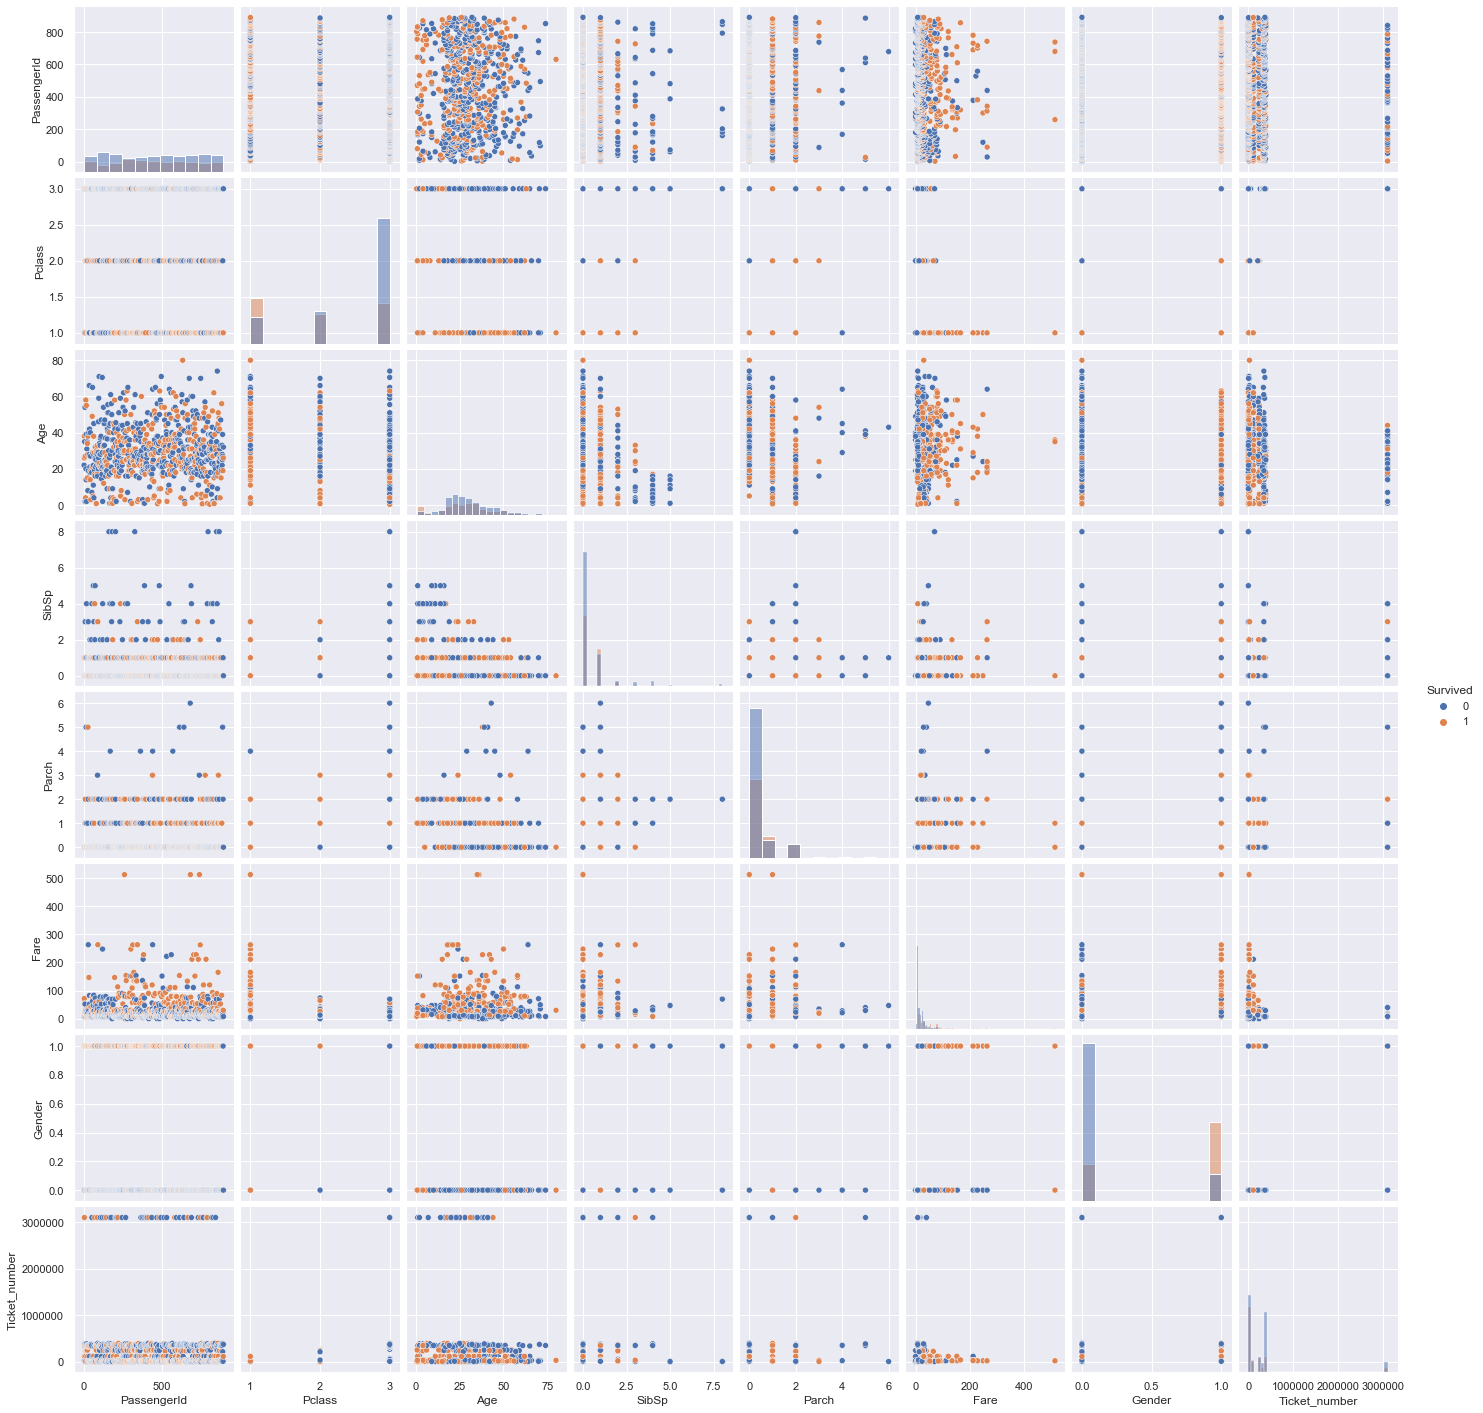

In [570]:
sns.pairplot(training_df, hue = 'Survived', diag_kind="hist")

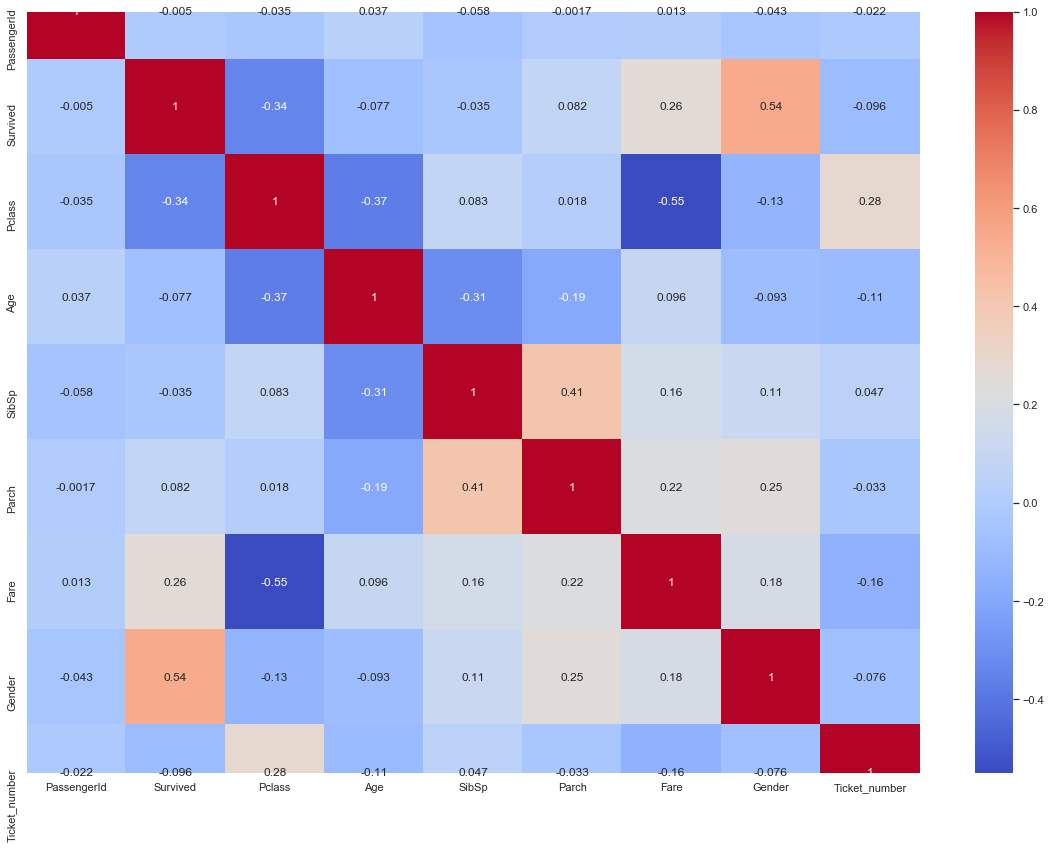

In [587]:
plt.figure(figsize=(20, 14))
sns.set(style="whitegrid")
corr = training_df.corr()
sns.heatmap(corr,annot=True,cmap="coolwarm")
ax.set_title('Correlation Map')
plt.show()

### Some observations in the pair plot above:
- Females (1) have a higher likelihood of surivival than males (0)
- 

### Time to do some binary encoding for categorical variables
- cabin group: A, B, C, etc
- embarked: S, C, S, etc 
- ticket prefix 

If passengers don't have those fields, then put 'None'

In [571]:
training_encode = training_df.copy()
training_encode['Cabin_group'].fillna('None', inplace=True)
training_encode['Embarked'].fillna('None', inplace=True)
training_encode['Ticket_prefix'].fillna('None', inplace=True)
training_encode.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Ticket_clean,Ticket_items,Ticket_number,Ticket_prefix,Cabin_list,Cabin_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,A5 21171,"[A5, 21171]",21171.0,A5,NaN,None
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,PC 17599,"[PC, 17599]",17599.0,PC,[C85],C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,STONO2 3101282,"[STONO2, 3101282]",3101282.0,STONO2,NaN,None
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,NA 113803,"[NA, 113803]",113803.0,NA,[C123],C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,NA 373450,"[NA, 373450]",373450.0,NA,NaN,None


In [448]:
# One hot encoding for these features
features = ['Cabin_group', 'Embarked', 'Ticket_prefix']

X = pd.get_dummies(training_encode[features])

training_encode = training_encode.join(X)
training_encode.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Ticket_prefix_SOP,Ticket_prefix_SOPP,Ticket_prefix_SOTONO2,Ticket_prefix_SOTONOQ,Ticket_prefix_SP,Ticket_prefix_STONO,Ticket_prefix_STONO2,Ticket_prefix_SWPP,Ticket_prefix_WC,Ticket_prefix_WEP
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,0,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,0,0,0


In [309]:
### Time to select columns to keep in the dataframe
training_select = training_encode.copy()
list(training_select.columns)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'Gender',
 'Ticket_clean',
 'Ticket_prefix',
 'Ticket_number',
 'Ticket_items',
 'Cabin_list',
 'Cabin_group',
 'Cabin_group_A',
 'Cabin_group_B',
 'Cabin_group_C',
 'Cabin_group_D',
 'Cabin_group_E',
 'Cabin_group_F',
 'Cabin_group_G',
 'Cabin_group_None',
 'Cabin_group_T',
 'Embarked_C',
 'Embarked_None',
 'Embarked_Q',
 'Embarked_S',
 'Ticket_prefix_A4',
 'Ticket_prefix_A5',
 'Ticket_prefix_AS',
 'Ticket_prefix_C',
 'Ticket_prefix_CA',
 'Ticket_prefix_CASOTON',
 'Ticket_prefix_FC',
 'Ticket_prefix_FCC',
 'Ticket_prefix_Fa',
 'Ticket_prefix_NA',
 'Ticket_prefix_PC',
 'Ticket_prefix_PP',
 'Ticket_prefix_PPP',
 'Ticket_prefix_SC',
 'Ticket_prefix_SCA4',
 'Ticket_prefix_SCAH',
 'Ticket_prefix_SCOW',
 'Ticket_prefix_SCPARIS',
 'Ticket_prefix_SCParis',
 'Ticket_prefix_SOC',
 'Ticket_prefix_SOP',
 'Ticket_prefix_SOPP',
 'Ticket_prefix_SOTONO2',
 'Ticket_prefix_SO

In [310]:
# removing columns not interested in
training_select = training_select.drop(columns=['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Cabin_group',
                                                'Embarked', 'Ticket_clean', 'Ticket_prefix','Ticket_items', 'Cabin_list'], axis = 1)

training_select.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Gender,Ticket_number,Cabin_group_A,Cabin_group_B,...,Ticket_prefix_SOP,Ticket_prefix_SOPP,Ticket_prefix_SOTONO2,Ticket_prefix_SOTONOQ,Ticket_prefix_SP,Ticket_prefix_STONO,Ticket_prefix_STONO2,Ticket_prefix_SWPP,Ticket_prefix_WC,Ticket_prefix_WEP
0,0,3,22.0,1,0,7.2500,0,21171.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,38.0,1,0,71.2833,1,17599.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,3,26.0,0,0,7.9250,1,3101282.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,35.0,1,0,53.1000,1,113803.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,35.0,0,0,8.0500,0,373450.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [311]:
# describe to make sure all columns are no longer categorical. 
training_select.describe(include='all')

,Survived,Pclass,Age,SibSp,Parch,Fare,Gender,Ticket_number,Cabin_group_A,Cabin_group_B,...,Ticket_prefix_SOP,Ticket_prefix_SOPP,Ticket_prefix_SOTONO2,Ticket_prefix_SOTONOQ,Ticket_prefix_SP,Ticket_prefix_STONO,Ticket_prefix_STONO2,Ticket_prefix_SWPP,Ticket_prefix_WC,Ticket_prefix_WEP
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,8.910000e+02,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.352413,2.969891e+05,0.016835,0.052750,...,0.001122,0.003367,0.002245,0.016835,0.001122,0.013468,0.006734,0.002245,0.011223,0.003367
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990,6.564383e+05,0.128725,0.223659,...,0.033501,0.057961,0.047351,0.128725,0.033501,0.115332,0.081830,0.047351,0.105403,0.057961
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,1.431250e+04,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.120580e+05,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,3.470820e+05,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,3.101317e+06,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [415]:
# there are 177 (891-714) passengers without age information --> let's autofill it with the mean age? 
#training_select['Age'].fillna(29.699118, inplace=True)
training_select['Age'].fillna((training_select['Age'].mean()), inplace = True)
training_select.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Gender,Ticket_number,Cabin_group_A,Cabin_group_B,...,Ticket_prefix_SOP,Ticket_prefix_SOPP,Ticket_prefix_SOTONO2,Ticket_prefix_SOTONOQ,Ticket_prefix_SP,Ticket_prefix_STONO,Ticket_prefix_STONO2,Ticket_prefix_SWPP,Ticket_prefix_WC,Ticket_prefix_WEP
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,8.910000e+02,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.352413,2.969891e+05,0.016835,0.052750,...,0.001122,0.003367,0.002245,0.016835,0.001122,0.013468,0.006734,0.002245,0.011223,0.003367
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429,0.477990,6.564383e+05,0.128725,0.223659,...,0.033501,0.057961,0.047351,0.128725,0.033501,0.115332,0.081830,0.047351,0.105403,0.057961
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,1.431250e+04,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200,0.000000,1.120580e+05,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000,3.470820e+05,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,3.101317e+06,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [482]:
#training_select.isnull().sum()
training_select.isnull().values.any()

False

### Time to normalize the columns that are not for binary encoding

In [417]:
from sklearn.preprocessing import MinMaxScaler

training_copy = training_select.copy()
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(training_copy), columns=training_copy.columns)
df_scaled

,Survived,Pclass,Age,SibSp,Parch,Fare,Gender,Ticket_number,Cabin_group_A,Cabin_group_B,...,Ticket_prefix_SOP,Ticket_prefix_SOPP,Ticket_prefix_SOTONO2,Ticket_prefix_SOTONOQ,Ticket_prefix_SP,Ticket_prefix_STONO,Ticket_prefix_STONO2,Ticket_prefix_SWPP,Ticket_prefix_WC,Ticket_prefix_WEP
0,0.0,1.0,0.271174,0.125,0.000000,0.014151,0.0,0.006826,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.472229,0.125,0.000000,0.139136,1.0,0.005675,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.321438,0.000,0.000000,0.015469,1.0,0.999989,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.434531,0.125,0.000000,0.103644,1.0,0.036695,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.434531,0.000,0.000000,0.015713,0.0,0.120417,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,0.5,0.334004,0.000,0.000000,0.025374,0.0,0.068208,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887,1.0,0.0,0.233476,0.000,0.000000,0.058556,1.0,0.036131,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,0.0,1.0,0.367921,0.125,0.333333,0.045771,1.0,0.002130,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
889,1.0,0.0,0.321438,0.000,0.000000,0.058556,0.0,0.035910,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [486]:
df_scaled.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Gender,Ticket_number,Cabin_group_A,Cabin_group_B,...,Ticket_prefix_SOP,Ticket_prefix_SOPP,Ticket_prefix_SOTONO2,Ticket_prefix_SOTONOQ,Ticket_prefix_SP,Ticket_prefix_STONO,Ticket_prefix_STONO2,Ticket_prefix_SWPP,Ticket_prefix_WC,Ticket_prefix_WEP
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,0.654321,0.367921,0.065376,0.063599,0.062858,0.352413,0.095762,0.016835,0.052750,...,0.001122,0.003367,0.002245,0.016835,0.001122,0.013468,0.006734,0.002245,0.011223,0.003367
std,0.486592,0.418036,0.163383,0.137843,0.134343,0.096995,0.477990,0.211664,0.128725,0.223659,...,0.033501,0.057961,0.047351,0.128725,0.033501,0.115332,0.081830,0.047351,0.105403,0.057961
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.271174,0.000000,0.000000,0.015440,0.000000,0.004615,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.367921,0.000000,0.000000,0.028213,0.000000,0.036132,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.434531,0.125000,0.000000,0.060508,1.000000,0.111914,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Create training and test set

In [473]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_scaled, test_size=0.2)

## Attempt 1: Logistic Regression with Sklearn

In [475]:
from sklearn.linear_model import LogisticRegression

X = train.drop(columns = ['Survived', 'Ticket_number'],  axis = 1)
X_test = test.drop(columns = ['Survived', 'Ticket_number'], axis = 1)
y = train['Survived']
y_test = np.array(test['Survived'])

model = LogisticRegression() # making the model a logistic regression one
model.fit(X, y)

LogisticRegression()

In [476]:
predictions = model.predict(X_test)
predictions

array([1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1.])

In [477]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_test, predictions)
C

array([[90, 23],
       [16, 50]])

In [478]:
C / C.astype(np.float).sum(axis=1)

array([[0.79646018, 0.34848485],
       [0.14159292, 0.75757576]])

In [487]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.776536312849162

## Attempt 2: Random Forest Classifier

In [480]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=500)
clf.fit(X,y)

RandomForestClassifier(n_estimators=500)

In [481]:
predictions= clf.predict(X_test)
clf.score(X_test, y_test)

0.776536312849162

## Attempt 3: Tensor flow attempt

In [503]:
X.shape

(712, 49)

In [532]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(49,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [533]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [534]:
model.fit(X, y, epochs=25)

Epoch 1/25
23/23 [==============================] - 1s 2ms/step - loss: 2.1311 - accuracy: 0.1919
Epoch 2/25
23/23 [==============================] - 0s 4ms/step - loss: 1.9442 - accuracy: 0.5614
Epoch 3/25
23/23 [==============================] - 0s 2ms/step - loss: 1.7510 - accuracy: 0.6631
Epoch 4/25
23/23 [==============================] - 0s 2ms/step - loss: 1.5207 - accuracy: 0.6816
Epoch 5/25
23/23 [==============================] - 0s 2ms/step - loss: 1.3195 - accuracy: 0.6481
Epoch 6/25
23/23 [==============================] - 0s 4ms/step - loss: 1.1049 - accuracy: 0.6356
Epoch 7/25
23/23 [==============================] - 0s 3ms/step - loss: 0.9298 - accuracy: 0.6609
Epoch 8/25
23/23 [==============================] - 0s 2ms/step - loss: 0.8134 - accuracy: 0.6619
Epoch 9/25
23/23 [==============================] - 0s 2ms/step - loss: 0.7015 - accuracy: 0.6992
Epoch 10/25
23/23 [==============================] - 0s 2ms/step - loss: 0.6503 - accuracy: 0.7292
Epoch 11/25
23/23 [

## Attempt 3b: Tensor flow SGD, mean squared error

In [539]:
# Declare a variable where we will store the input size of our model
# It should be equal to the number of variables you have
input_size = 49
# Declare the output size of the model
# It should be equal to the number of outputs you've got (for regressions that's usually 1)
output_size = 1

# Outline the model
# We lay out the model in 'Sequential'
# Note that there are no calculations involved - we are just describing our network
model = tf.keras.Sequential([
                            # Each 'layer' is listed here
                            # The method 'Dense' indicates, our mathematical operation to be (xw + b)
                            tf.keras.layers.Dense(output_size,
                                                 # there are extra arguments you can include to customize your model
                                                 # in our case we are just trying to create a solution that is 
                                                 # as close as possible to our NumPy model
                                                 kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1),
                                                 bias_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1)
                                                 )
                            ])

# We can also define a custom optimizer, where we can specify the learning rate
custom_optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
# Note that sometimes you may also need a custom loss function 
# That's much harder to implement and won't be covered in this course though

# 'compile' is the place where you select and indicate the optimizers and the loss
model.compile(optimizer=custom_optimizer, loss='mean_squared_error')

# finally we fit the model, indicating the inputs and targets
# if they are not otherwise specified the number of epochs will be 1 (a single epoch of training), 
# so the number of epochs is 'kind of' mandatory, too
# we can play around with verbose; we prefer verbose=2
model.fit(X, y, epochs=10, verbose=2)

Epoch 1/10
23/23 - 0s - loss: 0.1843
Epoch 2/10
23/23 - 0s - loss: 0.1522
Epoch 3/10
23/23 - 0s - loss: 0.1470
Epoch 4/10
23/23 - 0s - loss: 0.1476
Epoch 5/10
23/23 - 0s - loss: 0.1464
Epoch 6/10
23/23 - 0s - loss: 0.1431
Epoch 7/10
23/23 - 0s - loss: 0.1439
Epoch 8/10
23/23 - 0s - loss: 0.1422
Epoch 9/10
23/23 - 0s - loss: 0.1416
Epoch 10/10
23/23 - 0s - loss: 0.1406


In [540]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_test, model.predict_on_batch(X_test).round(0))
C

array([[109,   4],
       [ 30,  36]])

In [542]:
accuracy_score(y_test, model.predict_on_batch(X_test).round(0))

0.8100558659217877

## Attempt 3c: Antoher tensor flow from 
-https://builtin.com/data-science/guide-logistic-regression-tensorflow-20